###Description

Data were acquired with three sensors (2 accelerometers - ADXL345/MMA8451Q and 1 gyroscope - ITG3200) at a frequency sample of 200 Hz



---


**Dataset fields:**

| Field | Description | Datatype |
| --- | --- | -- |
| ADXL345_X | X-axis acceleration data (ADXL345) | int |
| ADXL345_Y | Y-axis acceleration data (ADXL345) | int | 
| ADXL345_Z | Z-axis acceleration data (ADXL345) | int |
| ITG3200_X | X-axis rotation data (ITG3200) | int |
| ITG3200_Y | Y-axis rotation data (ITG3200) | int |
| ITG3200_Z | Z-axis rotation data (ITG3200) | int |
| MMA8451Q_X | X-axis acceleration data (MMA8451Q) | int |
| MMA8451Q_Y | Y-axis acceleration data (MMA8451Q) | int |
| MMA8451Q_Z | Z-axis acceleration data (MMA8451Q) | int |
| subject | Test participant code | string |
| trial | Test trial # | string |
| code | Activity code | string |
| code_ref | Activity code description | string |
| age | Test participant age | int |
| height | Test participant height | int |
| weight | Test participant weight | float |
| gender | Test participant sex | string |
| *class* | *Fall/No Fall (predictor label)* | *int* |

## Import Libraries

In [1]:
import glob
import os
import math
import time
import pandas as pd
import numpy as np
import itertools
import scipy as sp
import scipy.signal
from scipy.stats import randint
from typing import List
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Download Dataset

In [ ]:
# Install googleDriveFileDownloader
!pip install googleDriveFileDownloader

In [ ]:
# Download SisFall dataset from google drive

from googleDriveFileDownloader import googleDriveFileDownloader
a = googleDriveFileDownloader()

a.downloadFile("https://drive.google.com/uc?id=1rJsYW0FMe_E9GQXxj4qZfyJjI2wStEOG&export=download")

In [ ]:
# Unzip SisFall dataset from zip file
!unzip -oq SisFall_Processed.zip

## Load Dataset

In [3]:
# Datatype Optimization Functions
def optimize_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df

def optimize_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df

def optimize_objects(df: pd.DataFrame, datetime_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']):
        if col not in datetime_features:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if float(num_unique_values) / num_total_values < 0.5:
                df[col] = df[col].astype('category')
        else:
            df[col] = pd.to_datetime(df[col])
    return df

def optimize(df: pd.DataFrame, datetime_features: List[str] = []):
    return optimize_floats(optimize_ints(optimize_objects(df, datetime_features)))

def LoadSisFallDataset():
 
    df = pd.read_csv("feature_data.csv")
    df = optimize(df, [])
    df.info()

    return df

feature_ds = LoadSisFallDataset()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7145 entries, 0 to 7144
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   mn_accx   7145 non-null   float32 
 1   mn_accy   7145 non-null   float32 
 2   mn_accz   7145 non-null   float32 
 3   mn_gyrox  7145 non-null   float32 
 4   mn_gyroy  7145 non-null   float32 
 5   mn_gyroz  7145 non-null   float32 
 6   mn_accx2  7145 non-null   float32 
 7   mn_accy2  7145 non-null   float32 
 8   mn_accz2  7145 non-null   float32 
 9   subject   7145 non-null   category
 10  code      7145 non-null   category
 11  class     7145 non-null   int8    
dtypes: category(2), float32(9), int8(1)
memory usage: 275.3 KB


## Data Exploration

In [4]:
def plotBoxplots(dataset, catFeat, numFeat, hueFeat):
  sns.set(style="ticks", palette="pastel")

  g = sns.boxplot(x=catFeat, y=numFeat, hue=hueFeat, data=dataset)
  sns.despine(offset=10, trim=True)
  plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

def plotScatter(dataset, x_feat, y_feat, hue_feat):
  sns.scatterplot(x=x_feat, y=y_feat, hue=hue_feat, data=dataset)

def getCorrelation(dataset, feat):
  corr_matrix = dataset.corr()
  #print(corr_matrix[feat].sort_values(ascending=False))
  feature_corr = corr_matrix[feat].sort_values(ascending=False)[1:]

  fig = plt.figure(figsize=(12,5))
  ax = feature_corr.plot(kind='bar')
  ax.set(ylabel='Correlation Coefficient')
  ax.set(xlabel='Feature')
  ax.set(title='Feature Correlation with class')
  ax.set(ylim =(-0.2,1))

def plotCorrelation(dataset):
  sns.heatmap(dataset.corr(), square=True, cmap='Blues')

def getCorrMatrix(dataset):
  _ = pd.plotting.scatter_matrix(datset, c=y, figsize=[8,8], s=150, marker='D')

def getCountPlot(dataset, catFeat, classFeat):
  sns.set(style="ggplot")
  sns.countplot(x=catFeat, hue=classFeat, data=dataset, palette='RdBu')
  plt.xticks([0,1], ['NoFall', 'Fall'])
  plt.show()

def getFactorPlot(dataset, catFeat, classFeat, hueFeat):
  sns.set(style="whitegrid")
  g = sns.factorplot(catFeat, classFeat, hueFeat,
                      data=dataset, kind="bar",
                      size=6, palette="muted",
                    legend_out=False)
  g.despine(left=True)
  g.set_ylabels("Fall probability")

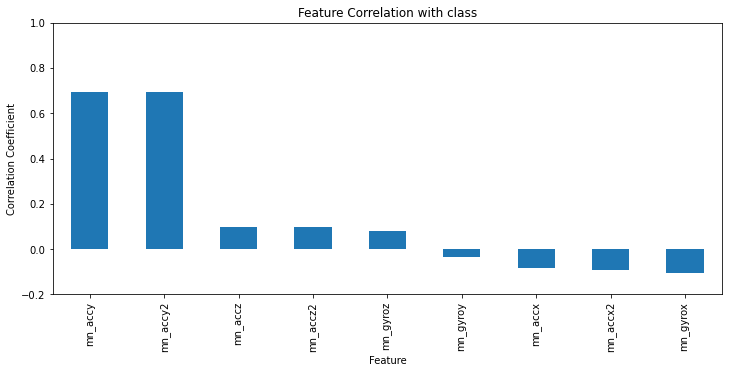

In [5]:
# Check correlation
getCorrelation(feature_ds, "class")

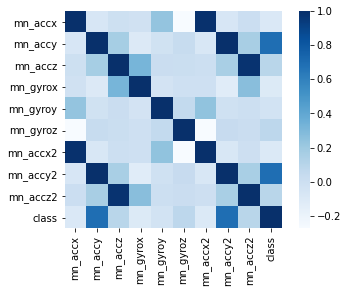

In [8]:
# Plot correlation matrix
plotCorrelation(feature_ds)

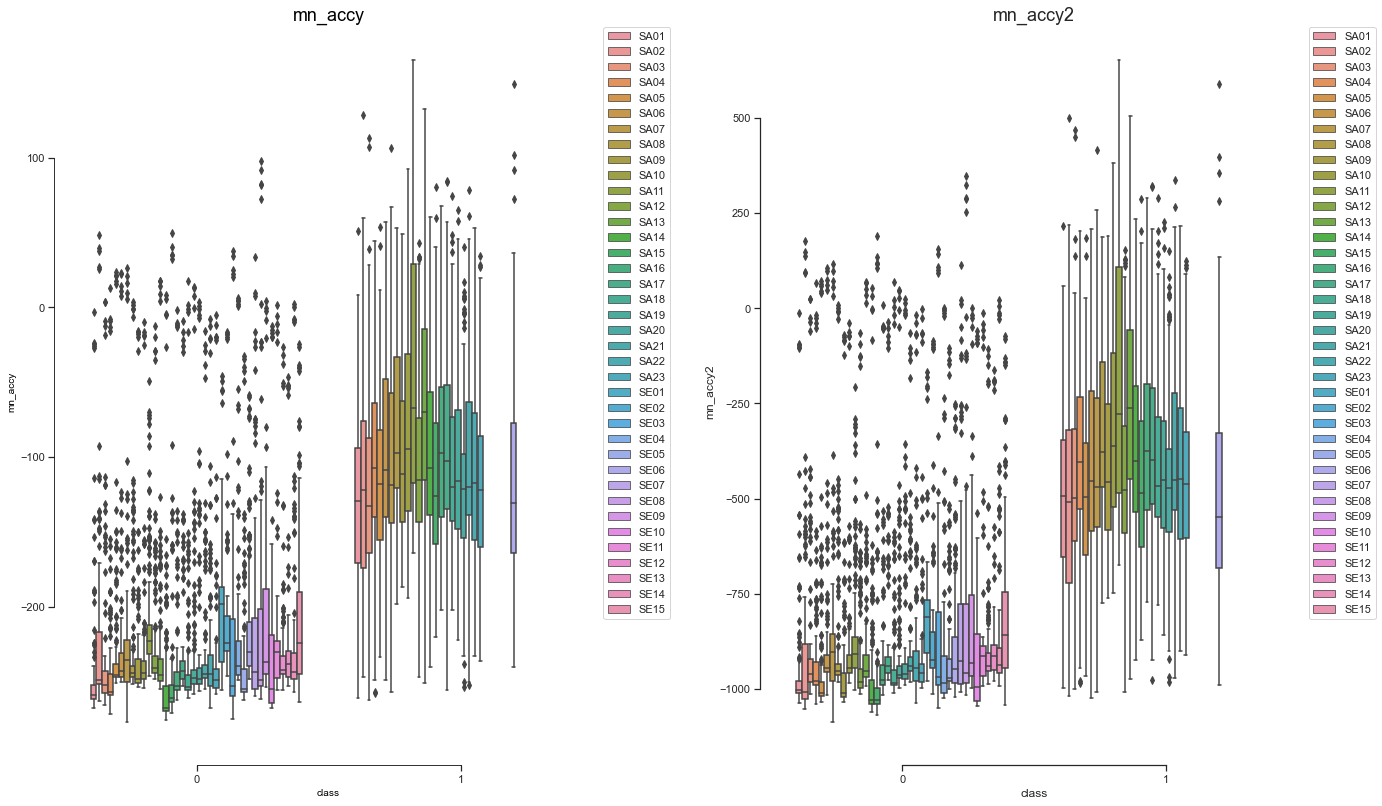

In [9]:
cols = ["mn_accy", "mn_accy2"]

fig=plt.figure(figsize=(20,12))
for i, feat in enumerate(cols):   
  fig.add_subplot(1,2,i+1)
  plotBoxplots(feature_ds, "class", feat, "subject")
  plt.title(cols[i], fontsize=18)

fig.tight_layout(pad=3.0)
plt.show()

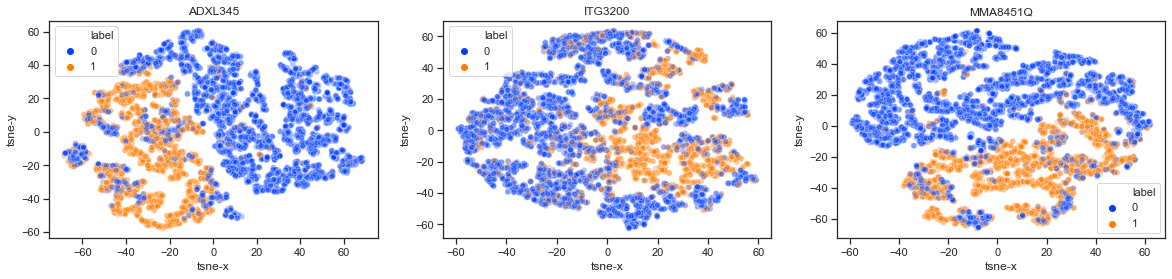

In [12]:
# Import TSNE
from sklearn.manifold import TSNE

def plotTSNE(name, features, label):
  # Create a TSNE instance: model
  model = TSNE(learning_rate=50, n_jobs=-1)

  # Apply fit_transform to normalized_movements: tsne_features
  tsne_features = model.fit_transform(features)

  # Select the 0th feature: xs
  xs = tsne_features[:,0]

  # Select the 1th feature: ys
  ys = tsne_features[:,1]
  
  df = pd.DataFrame({'tsne-x': xs, 'tsne-y': ys, 'label': label})  
  
  # Scatter plot
  #plt.scatter(xs, ys, c=label, alpha=0.5)
  #plt.title(name)

  sns.scatterplot(
    x="tsne-x", y="tsne-y",
    hue="label",
    palette=sns.color_palette("bright", 2),
    data=df,
    legend="full",
    alpha=0.3
  )
  plt.title(name)

mn_acc = feature_ds.iloc[:,:3]
mn_gyro = feature_ds.iloc[:,3:6]
mn_acc2 = feature_ds.iloc[:,6:9]
label = feature_ds.iloc[:,-1]

feature_spaces = {"ADXL345": mn_acc, "ITG3200": mn_gyro, "MMA8451Q": mn_acc2}

fig=plt.figure(figsize=(20,4))
for i, (name, features) in enumerate(feature_spaces.items()):   
  fig.add_subplot(1,len(feature_spaces),i+1)
  plotTSNE(name, features, label)

plt.show()

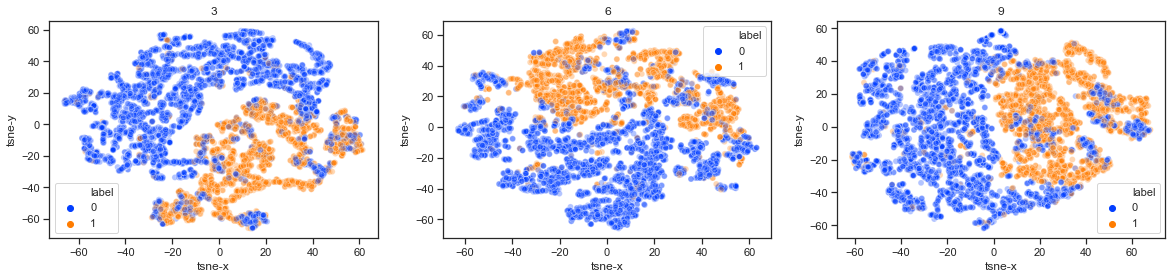

In [13]:
feat_3 = feature_ds.iloc[:,:3]
feat_6 = feature_ds.iloc[:,:6]
feat_9 = feature_ds.iloc[:,:9]
label = feature_ds.iloc[:,-1]

feature_spaces = {"3": feat_3, "6": feat_6, "9": feat_9}

fig=plt.figure(figsize=(20,4))
for i, (name, features) in enumerate(feature_spaces.items()):   
  fig.add_subplot(1,len(feature_spaces),i+1)
  plotTSNE(name, features, label)

plt.show()

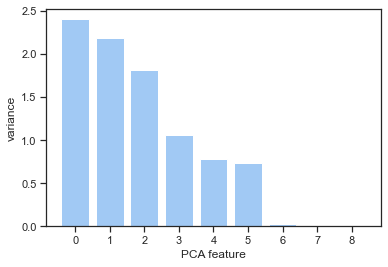

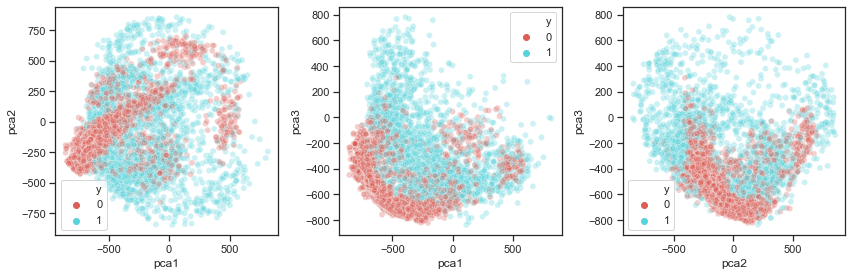

Text(0.5, 0, 'pca3')

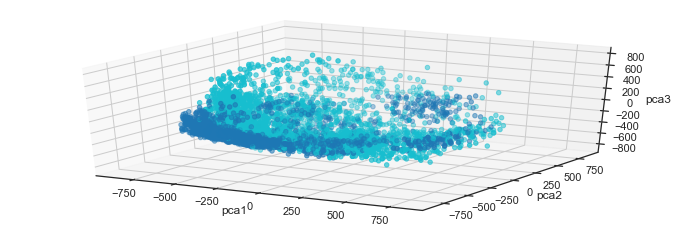

In [14]:
# Perform the necessary imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

X = feature_ds.iloc[:,:9]
Y = feature_ds.iloc[:,-1]
i = 9
# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA(n_components=i)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to 'samples'
pipeline.fit(X)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

variances = pd.DataFrame(pca.components_,columns=feature_ds.columns[:9],index = np.arange(1,i+1))
variances.style.highlight_max(color = 'yellow', axis=1).set_precision(3)

pca_result = pca.transform(X)
df_components = pd.DataFrame()
df_components['pca1'] = pca_result[:,0]
df_components['pca2'] = pca_result[:,1]
df_components['pca3'] = pca_result[:,2]
df_components['y'] = Y

# Get all unique combinations of classifier with a set size greater than or equal to 2
pcas = ["pca1", "pca2", "pca3"]
combo_pcas = [subset for subset in itertools.combinations(pcas, 2)]

fig = plt.figure(figsize=(12,4))
for i, combo_pca in enumerate(combo_pcas):   
  fig.add_subplot(1,len(pcas),i+1)
  sns.scatterplot(
      x=combo_pca[0], y=combo_pca[1],
      hue="y",
      palette=sns.color_palette("hls", 2),
      data=df_components,
      legend="full",
      alpha=0.3
  )
plt.tight_layout()
plt.show()

ax = plt.figure(figsize=(12,4)).gca(projection='3d')
ax.scatter(
    xs=df_components["pca1"], 
    ys=df_components["pca2"], 
    zs=df_components["pca3"], 
    c=df_components["y"],  
    cmap='tab10'
)
ax.set_xlabel('pca1')
ax.set_ylabel('pca2')
ax.set_zlabel('pca3')

D:\2020\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
D:\2020\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
D:\2020\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated.

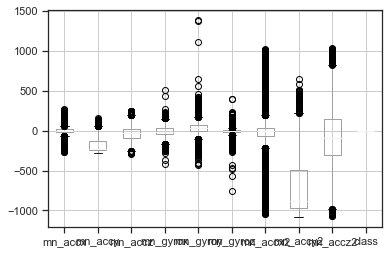

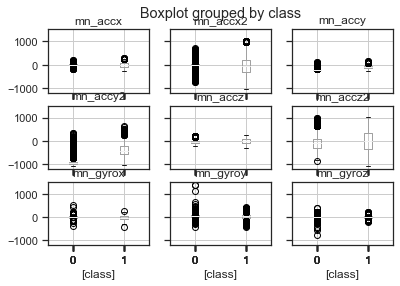

In [15]:
# Pandas boxplot method - Li wei

feature_ds.boxplot()
feature_ds.boxplot(by='class');

In [16]:
feature_ds.head()

,mn_accx,mn_accy,mn_accz,mn_gyrox,mn_gyroy,mn_gyroz,mn_accx2,mn_accy2,mn_accz2,subject,code,class
0,9.4415,-261.786011,-23.231501,-48.772499,14.789500,4.5160,35.3125,-1013.940491,27.6590,SA01,D01,0
1,6.4060,-261.466492,-25.416500,-36.922501,-111.258499,-0.0690,23.0495,-1012.829529,19.6035,SA01,D01,0
2,10.9115,-262.087006,-27.128000,-52.054501,15.048000,-17.5200,40.5495,-1015.268982,13.1785,SA01,D01,0
3,8.8575,-261.154510,-29.197001,-43.017502,23.433500,2.6635,32.6250,-1010.718018,5.0940,SA01,D01,0
4,8.4405,-262.714508,-30.641001,-45.166500,-99.740997,3.8530,31.1360,-1017.081482,-1.6325,SA01,D01,0


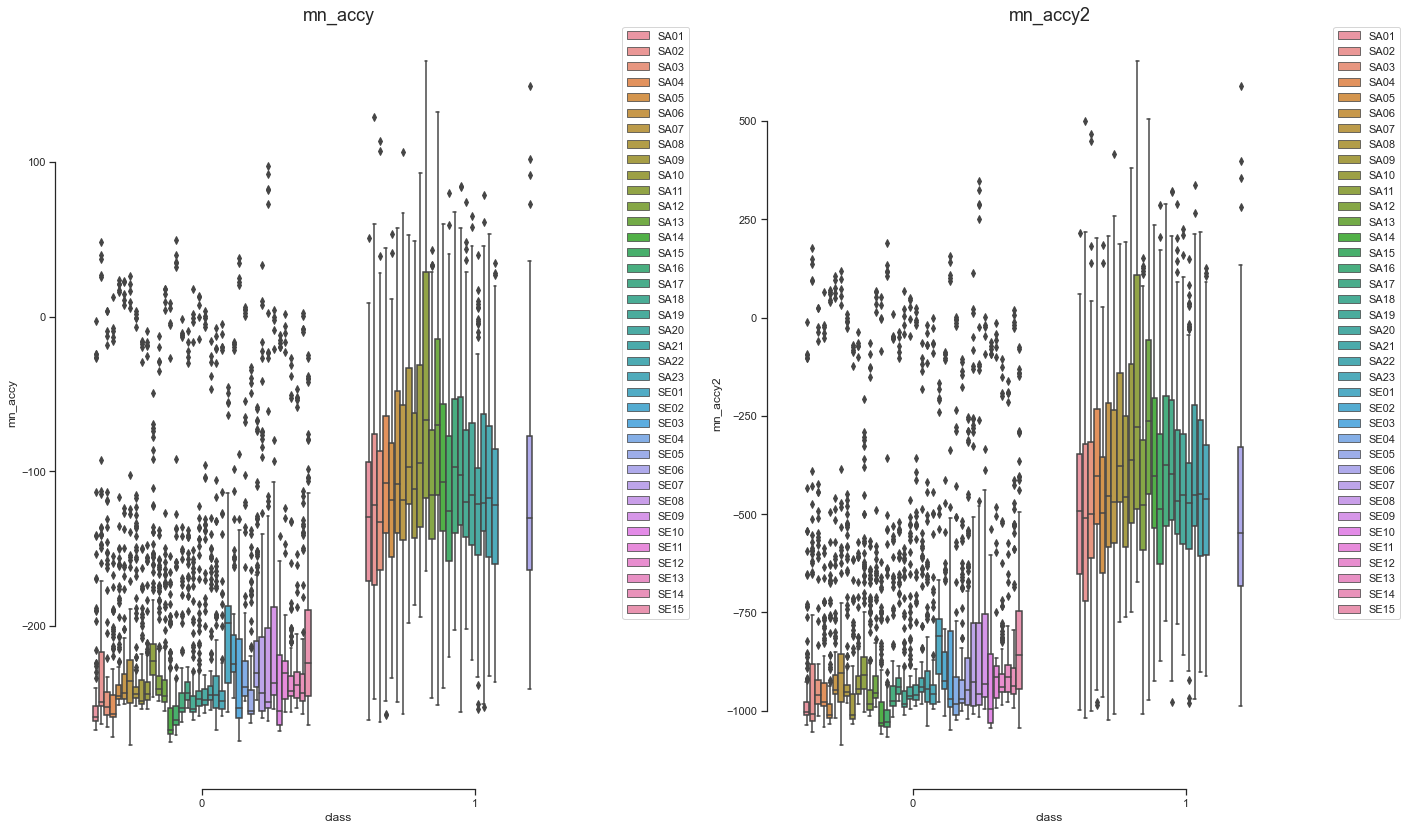

In [17]:
cols = ["mn_accy", "mn_accy2"]

fig=plt.figure(figsize=(20,12))
for i, feat in enumerate(cols):   
  fig.add_subplot(1,2,i+1)
  plotBoxplots(feature_ds, "class", feat, "subject")
  plt.title(cols[i], fontsize=18)

fig.tight_layout(pad=2.0)
plt.show()

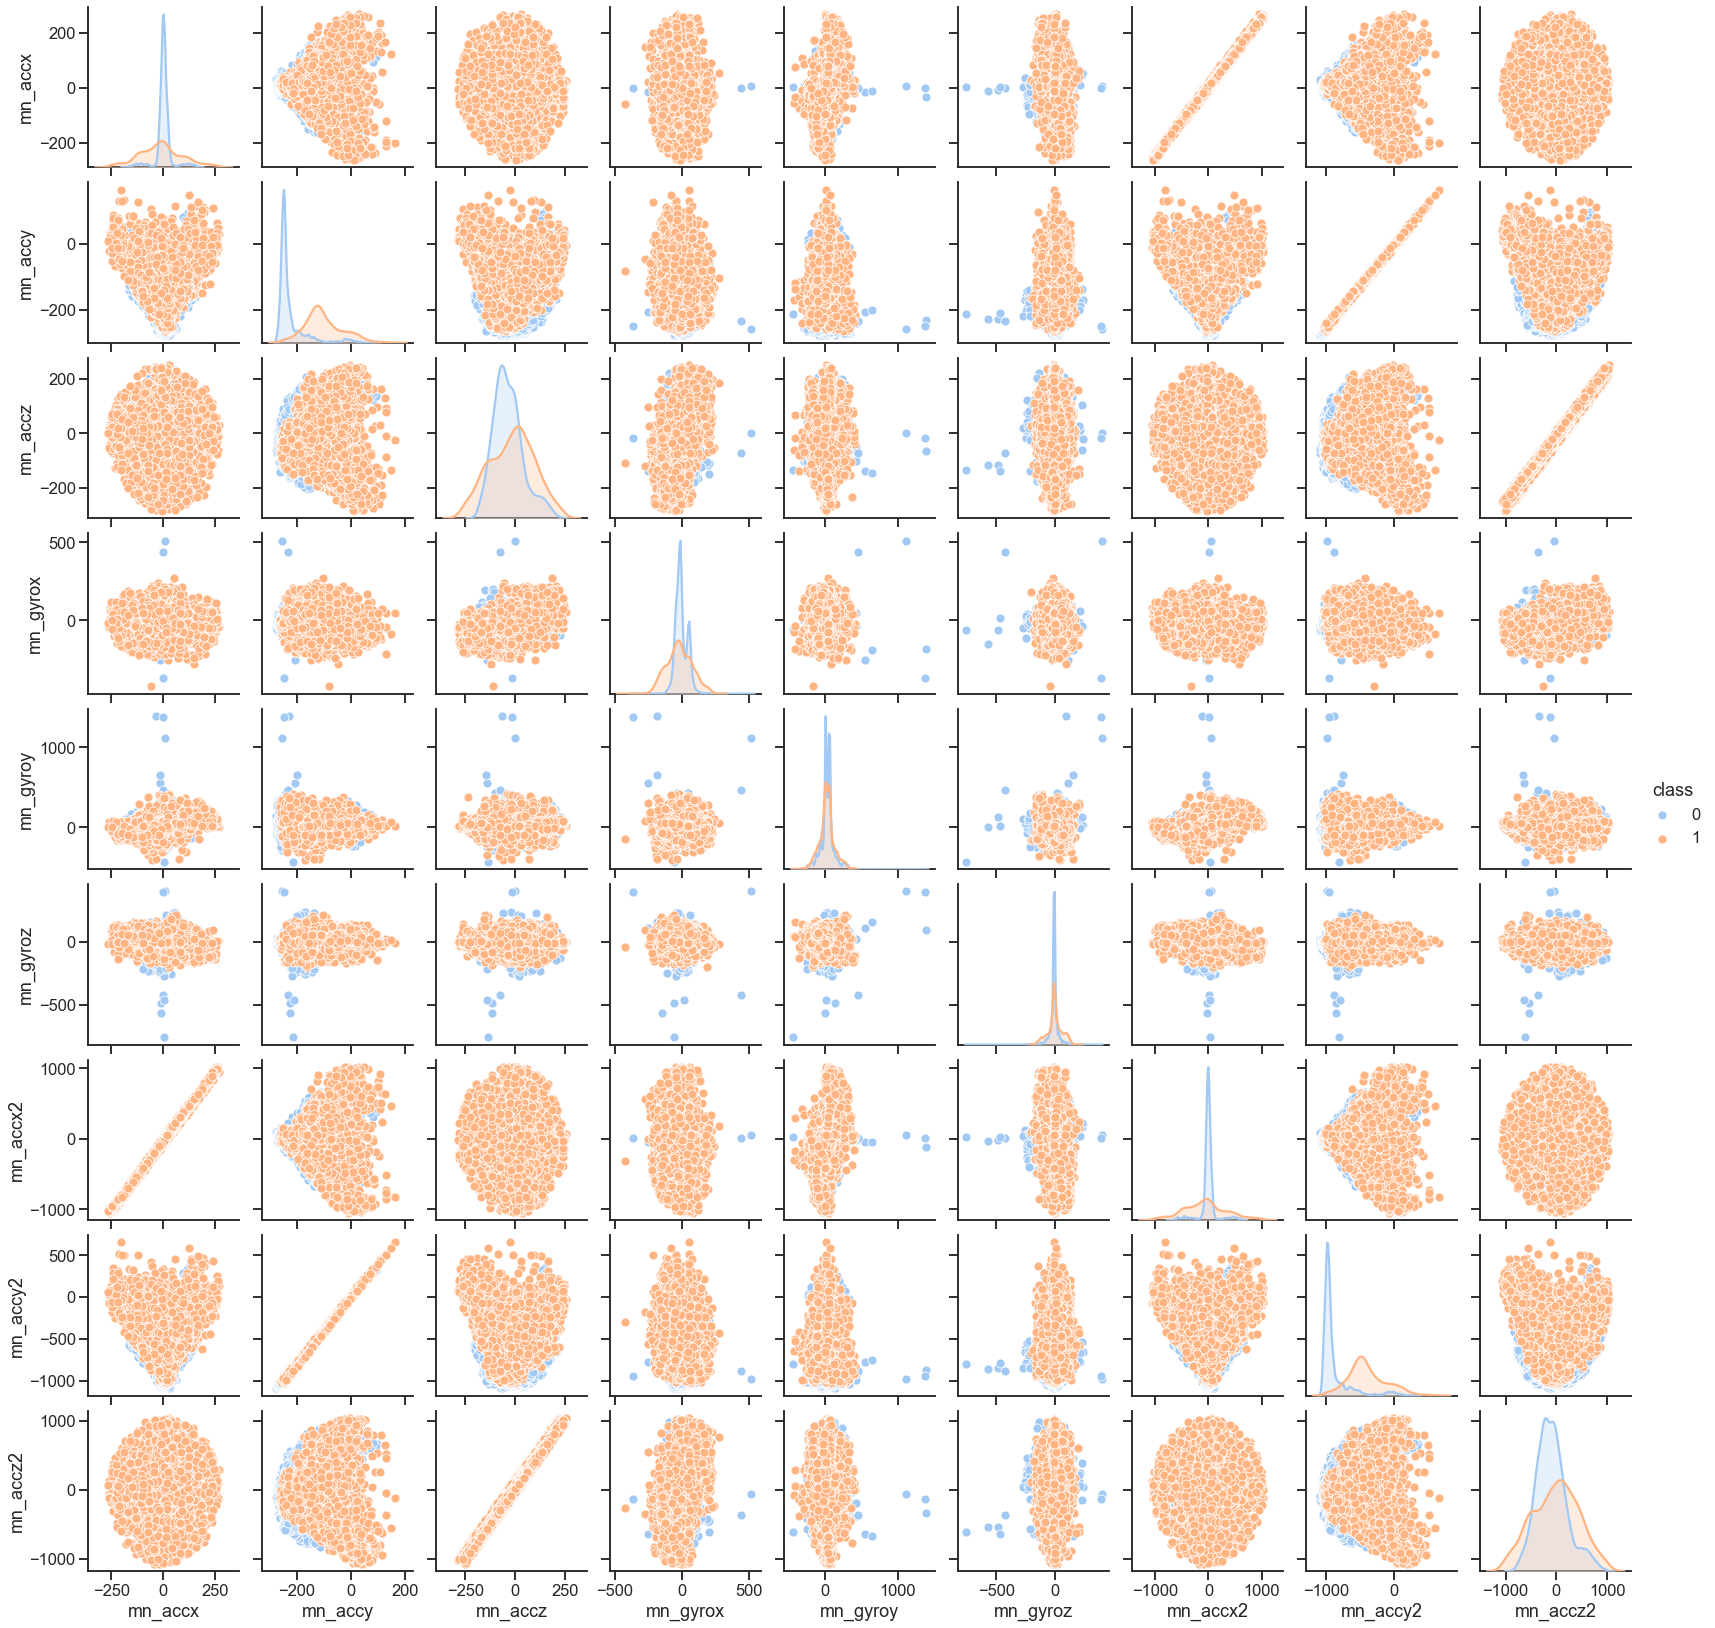

In [18]:
sns.set_context('talk')
sns.pairplot(feature_ds, hue='class');

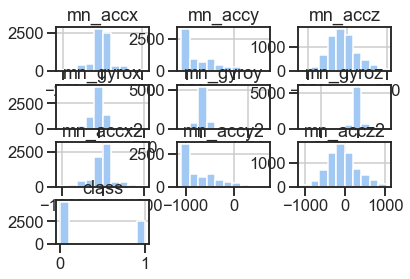

In [19]:
feature_ds.hist()
plt.show()

In [20]:
feature_ds.describe()

,mn_accx,mn_accy,mn_accz,mn_gyrox,mn_gyroy,mn_gyroz,mn_accx2,mn_accy2,mn_accz2,class
count,7145.000000,7145.000000,7145.000000,7145.000000,7145.000000,7145.000000,7145.000000,7145.000000,7145.000000,7145.000000
mean,-2.167427,-180.842026,-28.012415,-10.319660,35.101208,-4.323524,-22.554886,-708.839478,-60.426067,0.352134
std,68.819420,84.999283,89.798615,66.586731,98.336906,49.092270,269.584290,332.416687,364.957458,0.477669
min,-263.790009,-277.137512,-286.164490,-422.472992,-433.445496,-759.014526,-1050.415527,-1087.427002,-1069.864014,0.000000
25%,-15.898500,-247.755005,-88.991501,-43.872501,0.036500,-15.351000,-61.338001,-969.682495,-303.119995,0.000000
50%,0.911500,-224.268997,-34.794998,-14.143500,33.359501,-5.153500,-7.063500,-884.515015,-85.337997,0.000000
75%,16.363501,-125.808998,24.728001,34.862499,70.886497,6.296000,40.253502,-492.859009,148.693497,1.000000
max,269.101990,165.281998,250.644501,511.095490,1391.922485,397.926514,1019.479492,652.309509,1040.098511,1.000000


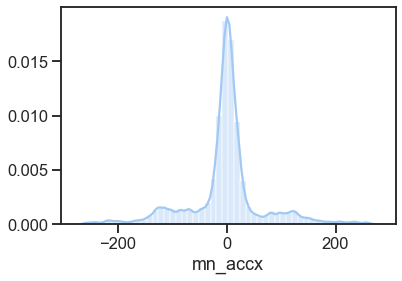

In [21]:
sns.distplot(feature_ds['mn_accx'], kde=True)
plt.show()

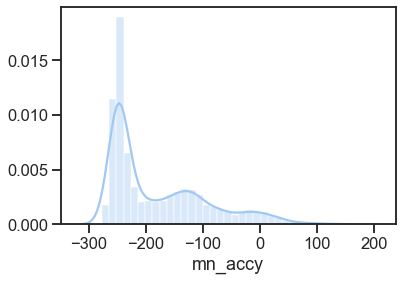

In [22]:
sns.distplot(feature_ds['mn_accy'], kde=True)
plt.show()

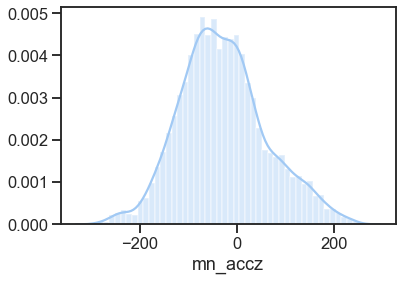

In [23]:
sns.distplot(feature_ds['mn_accz'], kde=True)
plt.show()

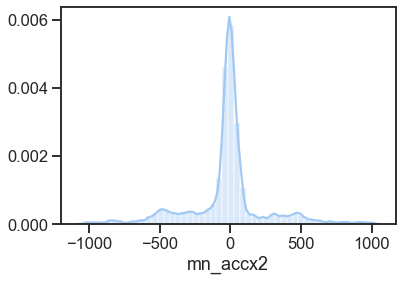

In [24]:
sns.distplot(feature_ds['mn_accx2'], kde=True)
plt.show()

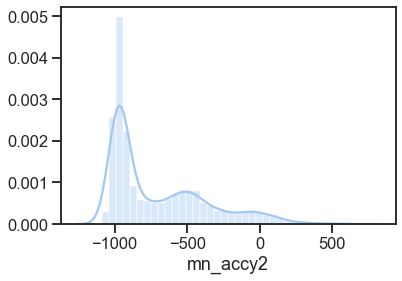

In [25]:
sns.distplot(feature_ds['mn_accy2'], kde=True)
plt.show()

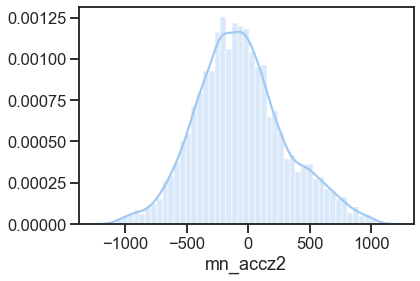

In [26]:
sns.distplot(feature_ds['mn_accz2'], kde=True)
plt.show()

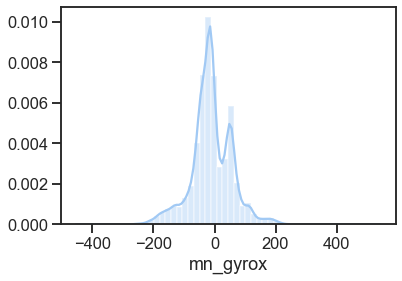

In [27]:
sns.distplot(feature_ds['mn_gyrox'], kde=True)
plt.show()

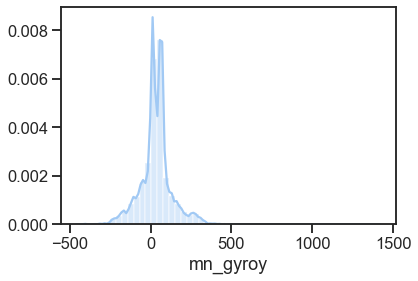

In [28]:
sns.distplot(feature_ds['mn_gyroy'], kde=True)
plt.show()

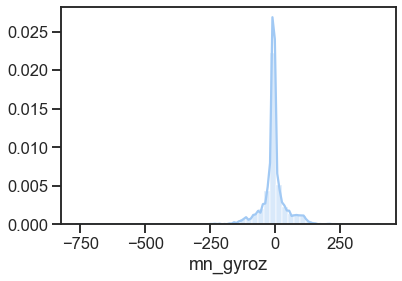

In [29]:
sns.distplot(feature_ds['mn_gyroz'], kde=True)
plt.show()

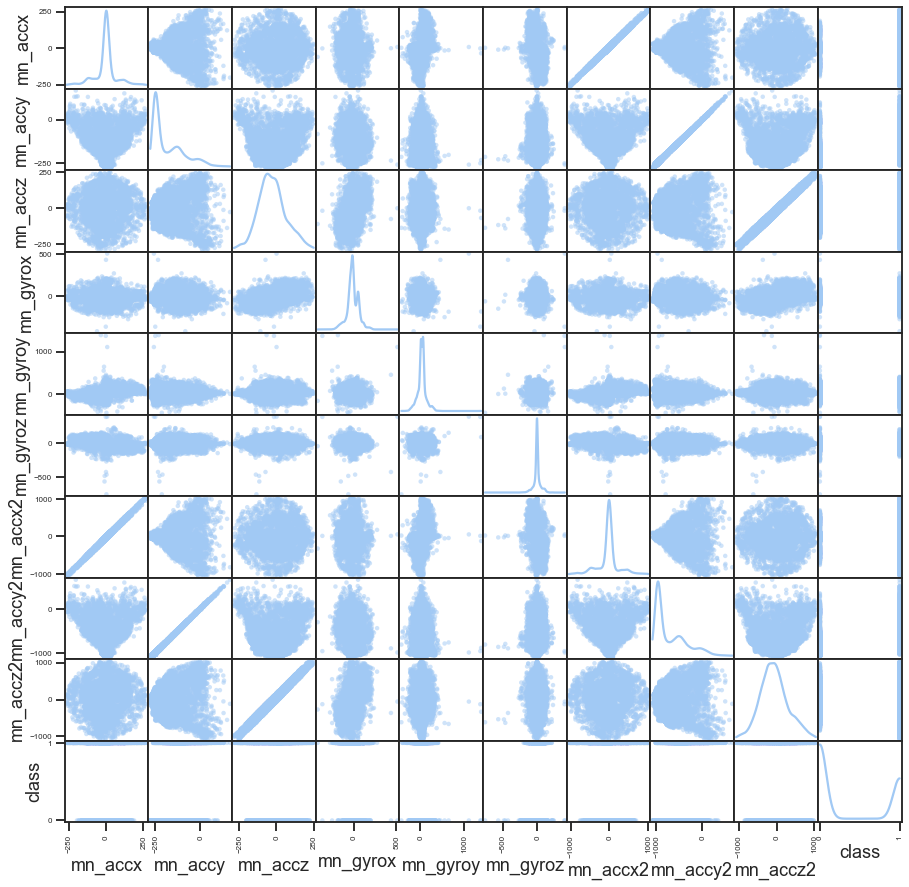

In [30]:
from pandas.plotting import scatter_matrix
scatter_matrix(feature_ds,figsize=(15.0,15.0),diagonal='kde',)
plt.show()